In [1]:
import sys
sys.path.append('../')

In [2]:
import time
import os

import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import tensorflow as tf
tf.__version__

'2.0.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [4]:
from tensorflow.keras.metrics import Metric
class RSquare(Metric):
    """Compute R^2 score.
     This is also called as coefficient of determination.
     It tells how close are data to the fitted regression line.
     - Highest score can be 1.0 and it indicates that the predictors
       perfectly accounts for variation in the target.
     - Score 0.0 indicates that the predictors do not
       account for variation in the target.
     - It can also be negative if the model is worse.
     Usage:
     ```python
     actuals = tf.constant([1, 4, 3], dtype=tf.float32)
     preds = tf.constant([2, 4, 4], dtype=tf.float32)
     result = tf.keras.metrics.RSquare()
     result.update_state(actuals, preds)
     print('R^2 score is: ', r1.result().numpy()) # 0.57142866
    ```
    """

    def __init__(self, name='r_square', dtype=tf.float32):
        super(RSquare, self).__init__(name=name, dtype=dtype)
        self.squared_sum = self.add_weight("squared_sum", initializer="zeros")
        self.sum = self.add_weight("sum", initializer="zeros")
        self.res = self.add_weight("residual", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        self.squared_sum.assign_add(tf.reduce_sum(y_true**2))
        self.sum.assign_add(tf.reduce_sum(y_true))
        self.res.assign_add(
            tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred))))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        mean = self.sum / self.count
        total = self.squared_sum - 2 * self.sum * mean + self.count * mean**2
        return 1 - (self.res / total)

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.squared_sum.assign(0.0)
        self.sum.assign(0.0)
        self.res.assign(0.0)
        self.count.assign(0.0)

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [6]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [7]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

## Data preparation

### Hyperparameters

In [8]:
BEST_PATHS       = ['./models/best_MLP.h5', 
                    './models/best_LSTM.h5',
                    './models/best_AE_LSTM.h5',
                    './models/best_BiLSTM.h5',
                    './models/best_AE_BiLSTM.h5']
TRANS_BEST_PATHS = ['./models/trans_MLP.h5', 
                    './models/trans_LSTM.h5',
                    './models/trans_AE_LSTM.h5',
                    './models/trans_BiLSTM.h5',
                    './models/trans_AE_BiLSTM.h5']
RAW_BEST_PATHS   = ['./models/raw_MLP.h5', 
                    './models/raw_LSTM.h5',
                    './models/raw_AE_LSTM.h5',
                    './models/raw_BiLSTM.h5',
                    './models/raw_AE_BiLSTM.h5']
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_HIDDEN = 256

### data loading

In [9]:
l = np.load('./env_set/val_dataset.npz')
train_input = l['train_input']
train_label = l['train_label']
test_input = l['test_input']
test_label = l['test_label']
MAXS = l['MAXS']
MINS = l['MINS']

TIME_STEPS = l['TIME_STEPS']
OUTPUT_SIZE = l['OUTPUT_SIZE']
NUM_FEATURES = train_input.shape[-1]

In [10]:
print(train_input.shape)
print(train_label.shape)
print()
print(test_input.shape)
print(test_label.shape)

(9731, 24, 5)
(9731, 24, 5)

(21084, 24, 5)
(21084, 24, 5)


In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

# Transfer learning - MLP

In [12]:
mlp_model_copy = tf.keras.models.load_model(BEST_PATHS[0])
mlp_model_copy.trainable = False

In [13]:
trans_mlp_model = tf.keras.Sequential([mlp_model_copy.get_layer(index=0), 
                                       mlp_model_copy.get_layer(index=1), 
                                       mlp_model_copy.get_layer(index=2), 
                                       mlp_model_copy.get_layer(index=3), 
                                       tf.keras.layers.Dense(test_label.shape[-1], name='retrain_dense')])

In [14]:
trans_mlp_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [15]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=TRANS_BEST_PATHS[0],
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [16]:
trans_mlp_model.fit(
    train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
141/144 [============================>.] - ETA: 0s - loss: 0.3142
Epoch 00001: val_loss improved from inf to 0.01696, saving model to ./models/trans_MLP.h5
144/144 [==============================] - 2s 15ms/step - loss: 0.3080 - val_loss: 0.0170
Epoch 2/150
142/144 [============================>.] - ETA: 0s - loss: 0.0125
Epoch 00002: val_loss improved from 0.01696 to 0.00849, saving model to ./models/trans_MLP.h5
144/144 [==============================] - 1s 7ms/step - loss: 0.0124 - val_loss: 0.0085
Epoch 3/150
142/144 [============================>.] - ETA: 0s - loss: 0.0095
Epoch 00003: val_loss improved from 0.00849 to 0.00736, saving model to ./models/trans_MLP.h5
144/144 [==============================] - 1s 7ms/step - loss: 0.0094 - val_loss: 0.0074
Epoch 4/150
142/144 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 00004: val_loss improved from 0.00736 to 0.00705, saving model to ./models/trans_MLP.h5
144/1

In [17]:
trans_mlp_model = tf.keras.models.load_model(TRANS_BEST_PATHS[0])
trans_mlp_model.trainable = True
trans_mlp_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
                   loss = tf.keras.losses.MeanSquaredError())

In [18]:
trans_mlp_model.fit(
    train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
142/144 [============================>.] - ETA: 0s - loss: 0.0076
Epoch 00001: val_loss did not improve from 0.00642
144/144 [==============================] - 2s 16ms/step - loss: 0.0076 - val_loss: 0.0065
Epoch 2/150
141/144 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 00002: val_loss did not improve from 0.00642
144/144 [==============================] - 1s 9ms/step - loss: 0.0080 - val_loss: 0.0064
Epoch 3/150
141/144 [============================>.] - ETA: 0s - loss: 0.0076
Epoch 00003: val_loss did not improve from 0.00642
144/144 [==============================] - 1s 9ms/step - loss: 0.0076 - val_loss: 0.0068
Epoch 4/150
141/144 [============================>.] - ETA: 0s - loss: 0.0079
Epoch 00004: val_loss improved from 0.00642 to 0.00632, saving model to ./models/trans_MLP.h5
144/144 [==============================] - 1s 9ms/step - loss: 0.0079 - val_loss: 0.0063
Epoch 5/150
142/144 [====================

In [19]:
raw_mlp_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(N_HIDDEN, input_shape=[TIME_STEPS, NUM_FEATURES]),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(N_HIDDEN),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(test_label.shape[-1])
])

In [20]:
raw_mlp_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [21]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=RAW_BEST_PATHS[0],
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [22]:
raw_mlp_model.fit(
    train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
143/144 [============================>.] - ETA: 0s - loss: 0.0771
Epoch 00001: val_loss improved from inf to 0.00807, saving model to ./models/raw_MLP.h5
144/144 [==============================] - 2s 16ms/step - loss: 0.0767 - val_loss: 0.0081
Epoch 2/150
143/144 [============================>.] - ETA: 0s - loss: 0.0089
Epoch 00002: val_loss improved from 0.00807 to 0.00780, saving model to ./models/raw_MLP.h5
144/144 [==============================] - 1s 9ms/step - loss: 0.0089 - val_loss: 0.0078
Epoch 3/150
142/144 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 00003: val_loss did not improve from 0.00780
144/144 [==============================] - 1s 9ms/step - loss: 0.0085 - val_loss: 0.0089
Epoch 4/150
142/144 [============================>.] - ETA: 0s - loss: 0.0090
Epoch 00004: val_loss did not improve from 0.00780
144/144 [==============================] - 1s 9ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 

### Model evaluation

In [23]:
mlp_model = tf.keras.models.load_model(BEST_PATHS[0])
trans_mlp_model = tf.keras.models.load_model(TRANS_BEST_PATHS[0])
raw_mlp_model = tf.keras.models.load_model(RAW_BEST_PATHS[0])

In [24]:
mlp_pred = mlp_model.predict(test_dataset)
trans_mlp_pred = trans_mlp_model.predict(test_dataset)
raw_mlp_pred = raw_mlp_model.predict(test_dataset)

[0, 50, 0, 50]

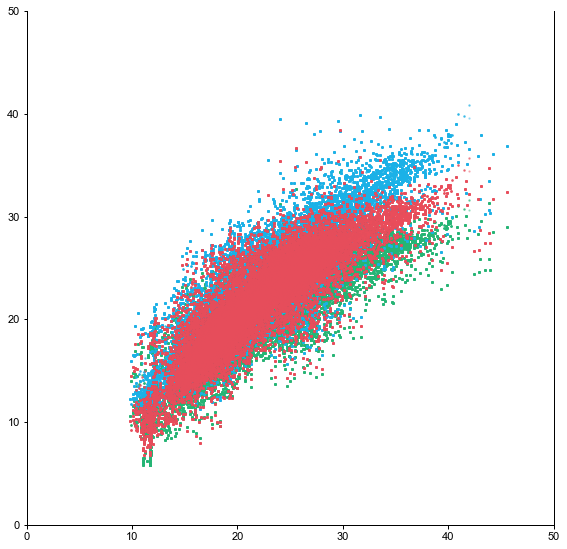

In [25]:
fig = plt.figure(figsize=((6/2.54)*4, (6/2.54)*4))

plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*mlp_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[3], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*raw_mlp_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[4], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*trans_mlp_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[0], s=2, alpha=0.3
           )
plt.axis([0,50,0,50])

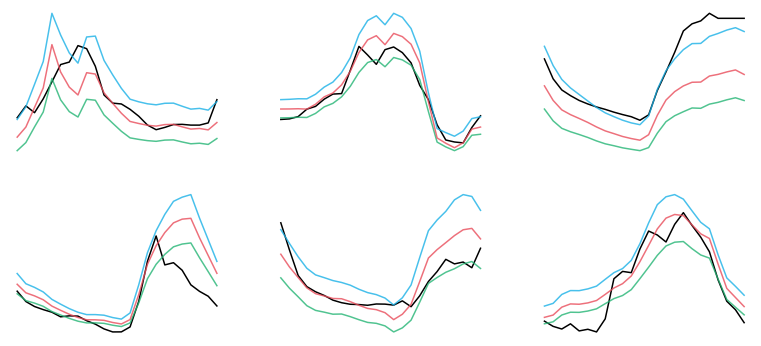

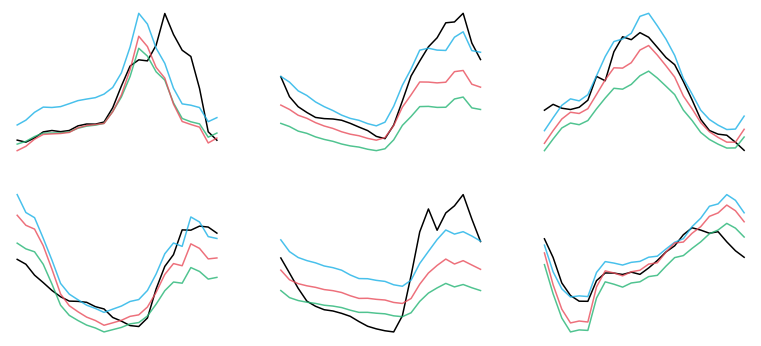

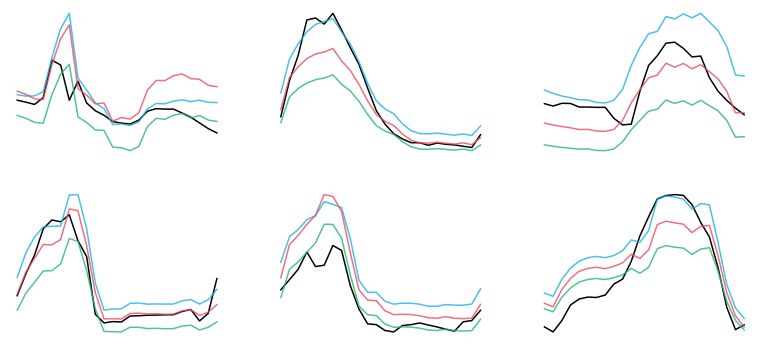

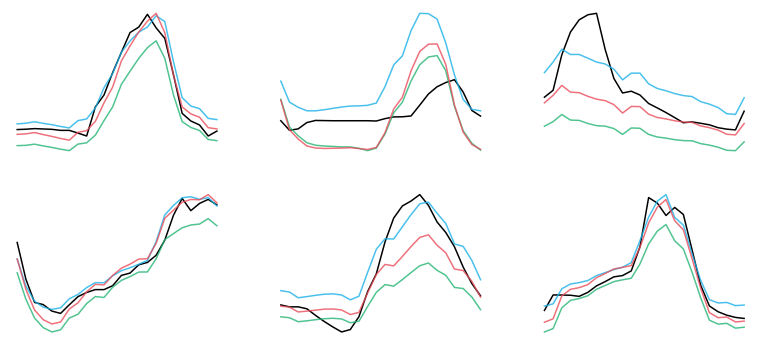

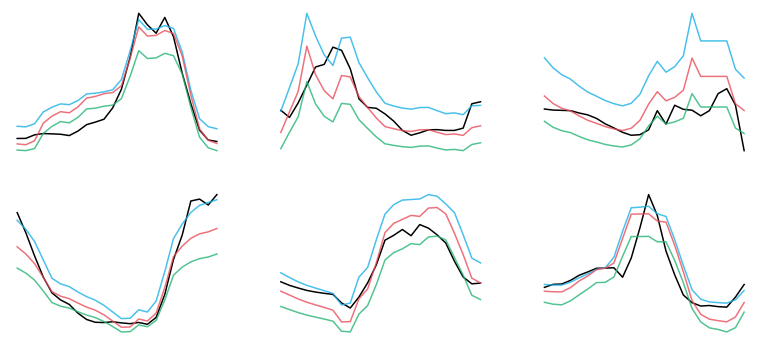

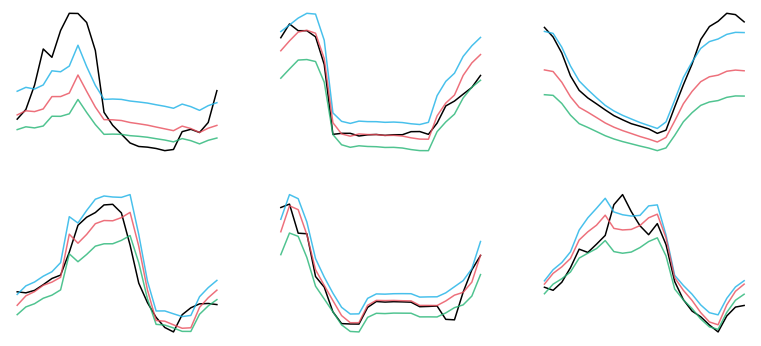

In [26]:
x_t = np.arange(0, test_label.shape[1])
for _ in range (6):

        NUMBERS = np.arange(1, mlp_pred.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*4, (6/2.54)*4))
        
        i=0
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, test_label[NUMBER, :, i], c='k', alpha=1) #measured
            expect1 = plt.plot(x_t, mlp_pred[NUMBER, :, i], c=cmap[3], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, raw_mlp_pred[NUMBER, :, i], c=cmap[4], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, trans_mlp_pred[NUMBER, :, i], c=cmap[0], alpha=0.8) #estimated
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1

# Transfer learning - LSTM

In [27]:
lstm_model_copy = tf.keras.models.load_model(BEST_PATHS[1])
lstm_model_copy.trainable = False

In [28]:
trans_lstm_model = tf.keras.Sequential([lstm_model_copy.get_layer(index=0), 
                                       lstm_model_copy.get_layer(index=1),
                                       tf.keras.layers.Dense(test_label.shape[-1], name='retrain_dense')])

In [29]:
trans_lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [30]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=TRANS_BEST_PATHS[1],
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [31]:
trans_lstm_model.fit(
    train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
143/144 [============================>.] - ETA: 0s - loss: 0.1560
Epoch 00001: val_loss improved from inf to 0.01041, saving model to ./models/trans_LSTM.h5
144/144 [==============================] - 7s 46ms/step - loss: 0.1550 - val_loss: 0.0104
Epoch 2/150
143/144 [============================>.] - ETA: 0s - loss: 0.0100
Epoch 00002: val_loss improved from 0.01041 to 0.00867, saving model to ./models/trans_LSTM.h5
144/144 [==============================] - 5s 36ms/step - loss: 0.0100 - val_loss: 0.0087
Epoch 3/150
143/144 [============================>.] - ETA: 0s - loss: 0.0079
Epoch 00003: val_loss improved from 0.00867 to 0.00708, saving model to ./models/trans_LSTM.h5
144/144 [==============================] - 5s 35ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 4/150
143/144 [============================>.] - ETA: 0s - loss: 0.0078
Epoch 00004: val_loss did not improve from 0.00708
144/144 [==============================] - 

In [32]:
trans_lstm_model = tf.keras.models.load_model(TRANS_BEST_PATHS[1])
trans_lstm_model.trainable = True
trans_lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
                   loss = tf.keras.losses.MeanSquaredError())

In [33]:
trans_lstm_model.fit(
    train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
143/144 [============================>.] - ETA: 0s - loss: 0.0059
Epoch 00001: val_loss did not improve from 0.00488
144/144 [==============================] - 7s 45ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 2/150
143/144 [============================>.] - ETA: 0s - loss: 0.0061
Epoch 00002: val_loss did not improve from 0.00488
144/144 [==============================] - 5s 36ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 3/150
143/144 [============================>.] - ETA: 0s - loss: 0.0059
Epoch 00003: val_loss did not improve from 0.00488
144/144 [==============================] - 5s 36ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 4/150
143/144 [============================>.] - ETA: 0s - loss: 0.0061
Epoch 00004: val_loss did not improve from 0.00488
144/144 [==============================] - 5s 36ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 5/150
142/144 [============================>.] - ETA: 0s - loss: 0.0057
Epo

In [34]:
raw_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(N_HIDDEN, input_shape=train_input.shape[-2:], return_sequences=True),
    tf.keras.layers.LayerNormalization(), # TEST
    tf.keras.layers.Dense(test_label.shape[-1])
])

In [35]:
raw_lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [36]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=RAW_BEST_PATHS[1],
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [37]:
raw_lstm_model.fit(
    train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
140/144 [============================>.] - ETA: 0s - loss: 0.0368
Epoch 00001: val_loss improved from inf to 0.00749, saving model to ./models/raw_LSTM.h5
144/144 [==============================] - 5s 32ms/step - loss: 0.0360 - val_loss: 0.0075
Epoch 2/150
138/144 [===========================>..] - ETA: 0s - loss: 0.0089
Epoch 00002: val_loss improved from 0.00749 to 0.00699, saving model to ./models/raw_LSTM.h5
144/144 [==============================] - 2s 12ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 3/150
140/144 [============================>.] - ETA: 0s - loss: 0.0074
Epoch 00003: val_loss did not improve from 0.00699
144/144 [==============================] - 2s 12ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 4/150
142/144 [============================>.] - ETA: 0s - loss: 0.0082
Epoch 00004: val_loss did not improve from 0.00699
144/144 [==============================] - 2s 12ms/step - loss: 0.0082 - val_loss: 0.0076
E

### Model evaluation

In [38]:
lstm_model = tf.keras.models.load_model(BEST_PATHS[1])
trans_lstm_model = tf.keras.models.load_model(TRANS_BEST_PATHS[1])
raw_lstm_model = tf.keras.models.load_model(RAW_BEST_PATHS[1])

In [39]:
lstm_pred = lstm_model.predict(test_dataset)
trans_lstm_pred = trans_lstm_model.predict(test_dataset)
raw_lstm_pred = raw_lstm_model.predict(test_dataset)

[0, 50, 0, 50]

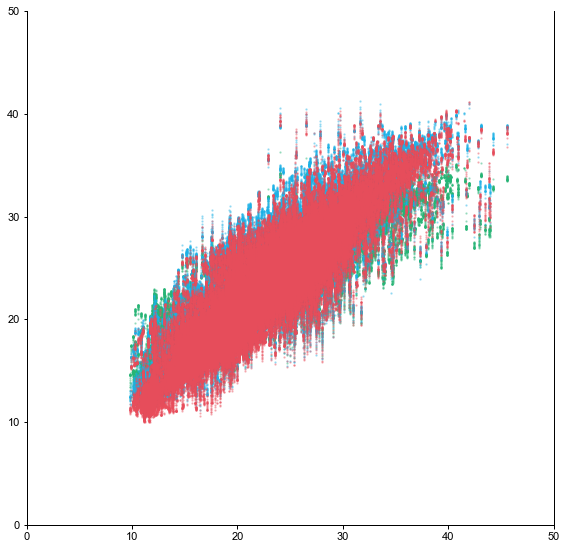

In [40]:
fig = plt.figure(figsize=((6/2.54)*4, (6/2.54)*4))

plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*lstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[3], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*raw_lstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[4], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*trans_lstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[0], s=2, alpha=0.3
           )
plt.axis([0,50,0,50])

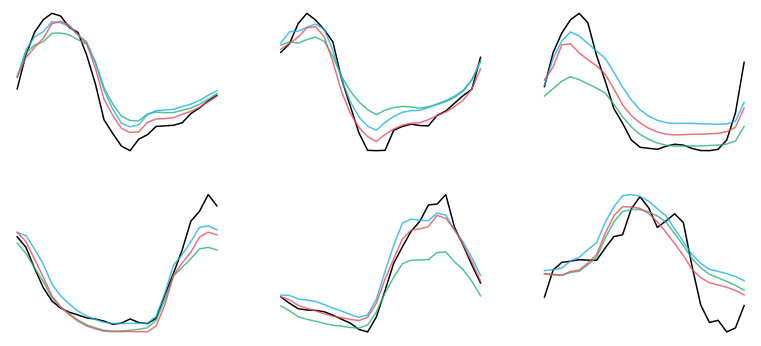

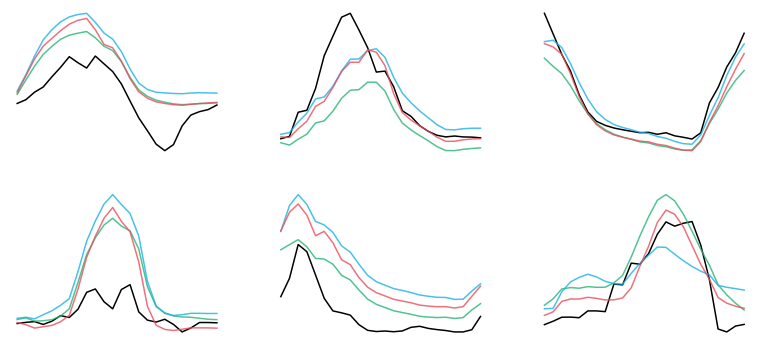

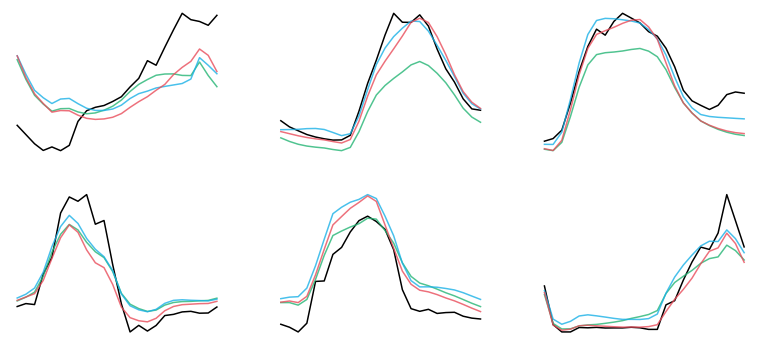

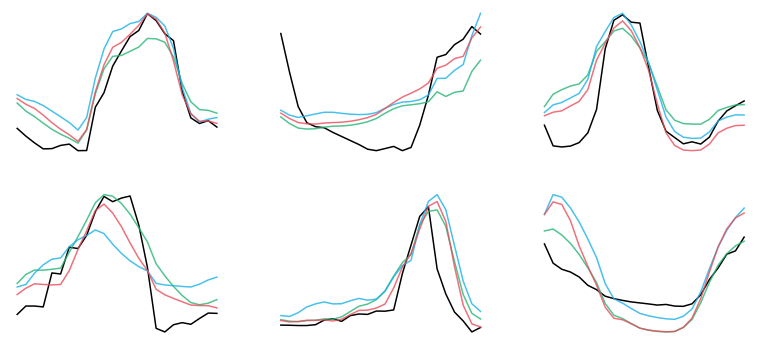

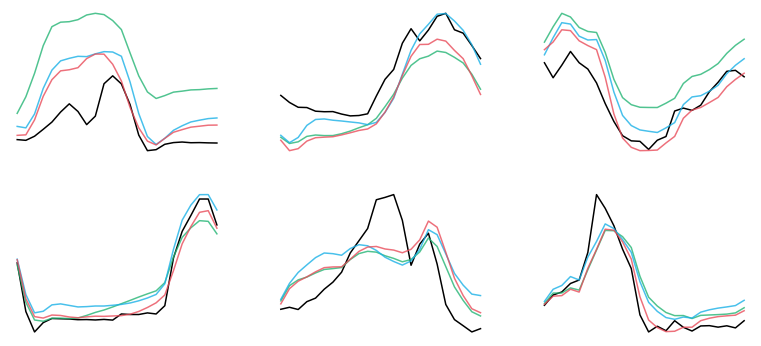

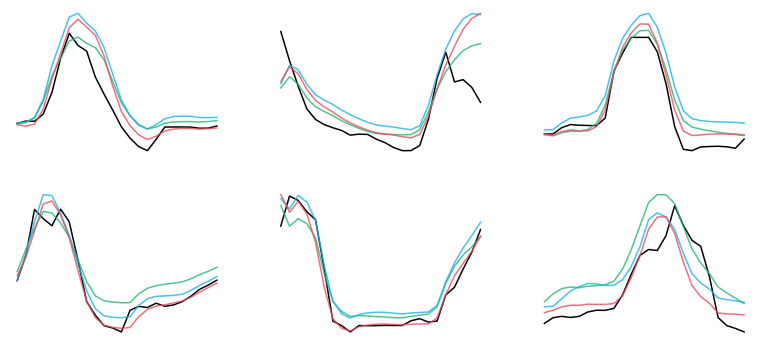

In [41]:
x_t = np.arange(0, test_label.shape[1])
for _ in range (6):

        NUMBERS = np.arange(1, lstm_pred.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*4, (6/2.54)*4))
        
        i=0
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, test_label[NUMBER, :, i], c='k', alpha=1) #measured
            expect1 = plt.plot(x_t, lstm_pred[NUMBER, :, i], c=cmap[3], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, raw_lstm_pred[NUMBER, :, i], c=cmap[4], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, trans_lstm_pred[NUMBER, :, i], c=cmap[0], alpha=0.8) #estimated
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1

# Transfer learning - BiLSTM

In [42]:
bilstm_model_copy = tf.keras.models.load_model(BEST_PATHS[3])
bilstm_model_copy.trainable = False

In [43]:
trans_bilstm_model = tf.keras.Sequential([bilstm_model_copy.get_layer(index=0), 
                                          bilstm_model_copy.get_layer(index=1),
                                          bilstm_model_copy.get_layer(index=2),
                                          bilstm_model_copy.get_layer(index=3),
                                       tf.keras.layers.Dense(test_label.shape[-1], name='retrain_dense')])

In [44]:
trans_bilstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [45]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=TRANS_BEST_PATHS[3],
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [46]:
trans_bilstm_model.fit(
    train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
143/144 [============================>.] - ETA: 0s - loss: 0.0543
Epoch 00001: val_loss improved from inf to 0.01929, saving model to ./models/trans_BiLSTM.h5
144/144 [==============================] - 19s 129ms/step - loss: 0.0541 - val_loss: 0.0193
Epoch 2/150
143/144 [============================>.] - ETA: 0s - loss: 0.0153
Epoch 00002: val_loss improved from 0.01929 to 0.01244, saving model to ./models/trans_BiLSTM.h5
144/144 [==============================] - 14s 94ms/step - loss: 0.0152 - val_loss: 0.0124
Epoch 3/150
143/144 [============================>.] - ETA: 0s - loss: 0.0106
Epoch 00003: val_loss improved from 0.01244 to 0.00938, saving model to ./models/trans_BiLSTM.h5
144/144 [==============================] - 14s 96ms/step - loss: 0.0106 - val_loss: 0.0094
Epoch 4/150
143/144 [============================>.] - ETA: 0s - loss: 0.0091
Epoch 00004: val_loss improved from 0.00938 to 0.00859, saving model to ./models/tra

In [47]:
trans_bilstm_model = tf.keras.models.load_model(TRANS_BEST_PATHS[3])
trans_bilstm_model.trainable = True
trans_bilstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
                   loss = tf.keras.losses.MeanSquaredError())

In [48]:
trans_bilstm_model.fit(
    train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
143/144 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 00001: val_loss improved from 0.00461 to 0.00457, saving model to ./models/trans_BiLSTM.h5
144/144 [==============================] - 18s 126ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 2/150
143/144 [============================>.] - ETA: 0s - loss: 0.0052
Epoch 00002: val_loss did not improve from 0.00457
144/144 [==============================] - 14s 97ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 3/150
143/144 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 00003: val_loss improved from 0.00457 to 0.00436, saving model to ./models/trans_BiLSTM.h5
144/144 [==============================] - 14s 98ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 4/150
143/144 [============================>.] - ETA: 0s - loss: 0.0052
Epoch 00004: val_loss did not improve from 0.00436
144/144 [==============================] - 14s 95ms/step - loss: 0.0052 - v

In [49]:
raw_bilstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(N_HIDDEN, input_shape=train_input.shape[-2:], return_sequences=True),
    tf.keras.layers.LayerNormalization(), # TEST
    tf.keras.layers.Dense(test_label.shape[-1])
])

In [50]:
raw_bilstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [51]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=RAW_BEST_PATHS[3],
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [52]:
raw_bilstm_model.fit(
    train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
140/144 [============================>.] - ETA: 0s - loss: 0.0498
Epoch 00001: val_loss improved from inf to 0.00861, saving model to ./models/raw_BiLSTM.h5
144/144 [==============================] - 4s 28ms/step - loss: 0.0487 - val_loss: 0.0086
Epoch 2/150
139/144 [===========================>..] - ETA: 0s - loss: 0.0093
Epoch 00002: val_loss improved from 0.00861 to 0.00827, saving model to ./models/raw_BiLSTM.h5
144/144 [==============================] - 2s 12ms/step - loss: 0.0093 - val_loss: 0.0083
Epoch 3/150
139/144 [===========================>..] - ETA: 0s - loss: 0.0077
Epoch 00003: val_loss improved from 0.00827 to 0.00636, saving model to ./models/raw_BiLSTM.h5
144/144 [==============================] - 2s 12ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 4/150
143/144 [============================>.] - ETA: 0s - loss: 0.0078
Epoch 00004: val_loss did not improve from 0.00636
144/144 [==============================] - 

### Model evaluation

In [53]:
bilstm_model = tf.keras.models.load_model(BEST_PATHS[3])
trans_bilstm_model = tf.keras.models.load_model(TRANS_BEST_PATHS[3])
raw_bilstm_model = tf.keras.models.load_model(RAW_BEST_PATHS[3])

In [54]:
bilstm_pred = bilstm_model.predict(test_dataset)
trans_bilstm_pred = trans_bilstm_model.predict(test_dataset)
raw_bilstm_pred = raw_bilstm_model.predict(test_dataset)

[0, 50, 0, 50]

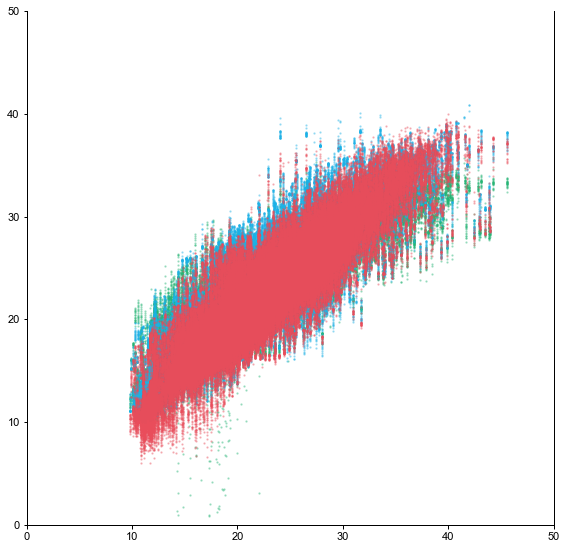

In [55]:
fig = plt.figure(figsize=((6/2.54)*4, (6/2.54)*4))

plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*bilstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[3], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*raw_bilstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[4], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*trans_bilstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[0], s=2, alpha=0.3
           )
plt.axis([0,50,0,50])

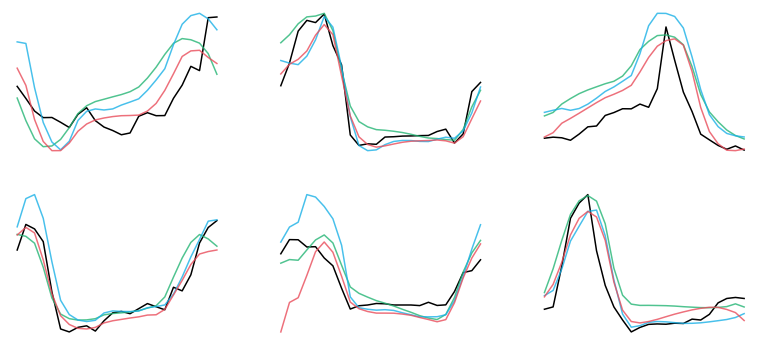

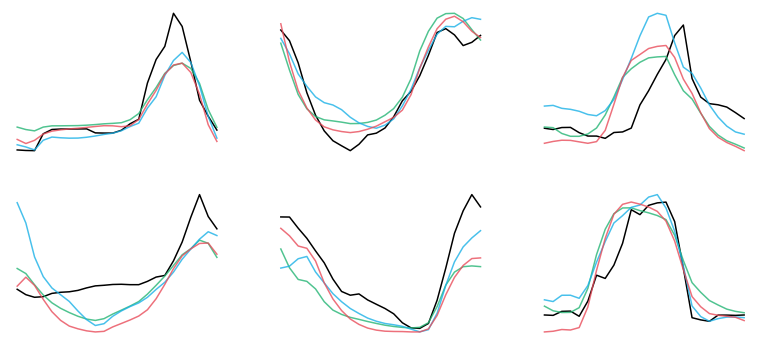

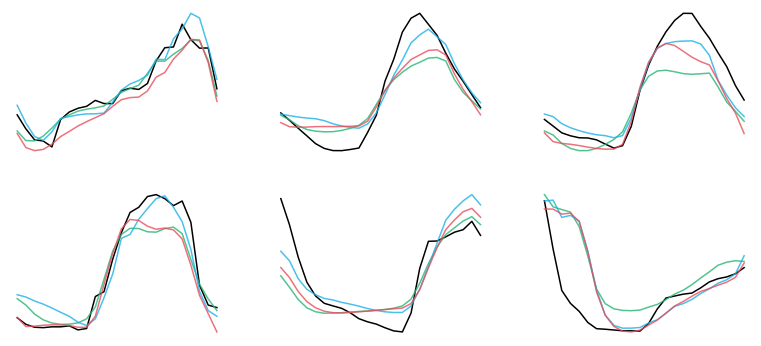

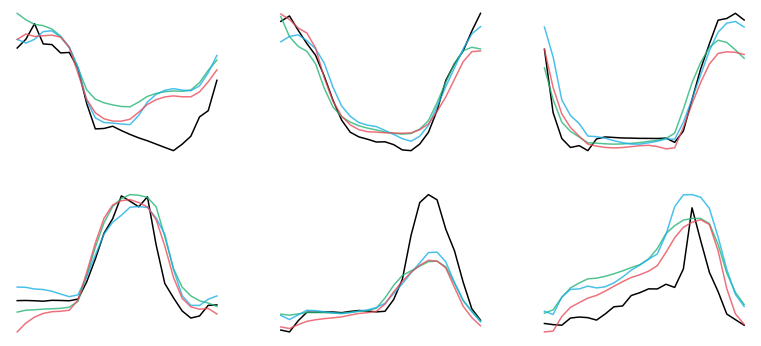

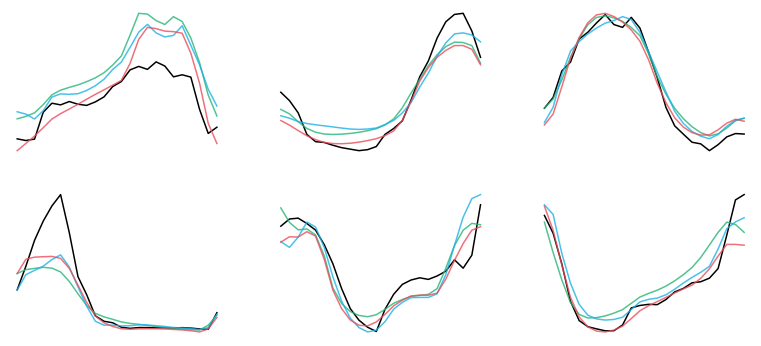

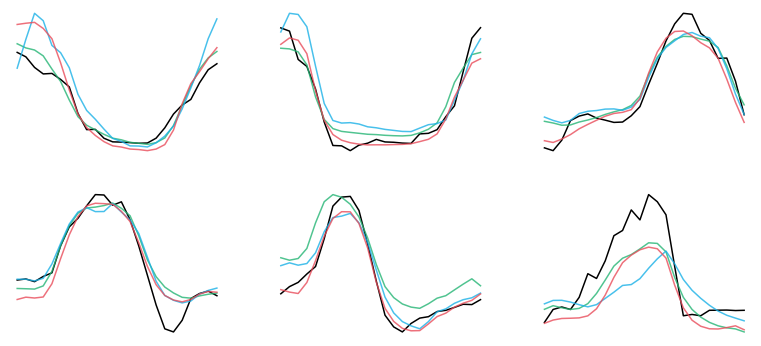

In [56]:
x_t = np.arange(0, test_label.shape[1])
for _ in range (6):

        NUMBERS = np.arange(1, bilstm_pred.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*4, (6/2.54)*4))
        
        i=0
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, test_label[NUMBER, :, i], c='k', alpha=1) #measured
            expect1 = plt.plot(x_t, bilstm_pred[NUMBER, :, i], c=cmap[3], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, raw_bilstm_pred[NUMBER, :, i], c=cmap[4], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, trans_bilstm_pred[NUMBER, :, i], c=cmap[0], alpha=0.8) #estimated
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1

In [58]:
mlp_pred = tf.cast((MAXS-MINS)*mlp_pred + MINS, tf.float32).numpy()
lstm_pred = tf.cast((MAXS-MINS)*lstm_pred + MINS, tf.float32).numpy()
bilstm_pred = tf.cast((MAXS-MINS)*bilstm_pred + MINS, tf.float32).numpy()
raw_mlp_pred = tf.cast((MAXS-MINS)*raw_mlp_pred + MINS, tf.float32).numpy()
raw_lstm_pred = tf.cast((MAXS-MINS)*raw_lstm_pred + MINS, tf.float32).numpy()
raw_bilstm_pred = tf.cast((MAXS-MINS)*raw_bilstm_pred + MINS, tf.float32).numpy()
trans_mlp_pred = tf.cast((MAXS-MINS)*trans_mlp_pred + MINS, tf.float32).numpy()
trans_lstm_pred = tf.cast((MAXS-MINS)*trans_lstm_pred + MINS, tf.float32).numpy()
trans_bilstm_pred = tf.cast((MAXS-MINS)*trans_bilstm_pred + MINS, tf.float32).numpy()

In [59]:
pd.DataFrame(((MAXS-MINS)*test_label + MINS).reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_tr_test_label.csv')

In [65]:
pd.DataFrame(mlp_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_prev_mlp_pred.csv')
pd.DataFrame(lstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_prev_lstm_pred.csv')
pd.DataFrame(bilstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_prev_bilstm_pred.csv')
pd.DataFrame(raw_mlp_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_raw_mlp_pred.csv')
pd.DataFrame(raw_lstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_raw_lstm_pred.csv')
pd.DataFrame(raw_bilstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_raw_bilstm_pred.csv')
pd.DataFrame(trans_mlp_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_tr_mlp_pred.csv')
pd.DataFrame(trans_lstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_tr_lstm_pred.csv')
pd.DataFrame(trans_bilstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_tr_bilstm_pred.csv')